# Density Estimation (Smoothing) and Local Regression

## Eric Feigelson 
## Summer School in Statistics for Astronomers


**Adapted from R scripts in Appendix B,  *Modern Statistical Methods for Astronomy With R Applications*,  Eric D. Feigelson & G. Jogesh Babu 2012  http://astrostatistics.psu.edu/MSMA**




Nonparametric density estimation seeks an optimal continuous curve derived from low-dimensional point processes.  Astronomers call this 'smoothing the data'.  As with regression, a response variable ('y' axis) must be chosen so that the dispersion in that variable is minimized in some fashion.  Typically, a smoothing 'bandwidth' must be chosen or calculated.  Too large a bandwidth will miss structural details (increase bias) while too small a bandwidth will add noise (increase variance).  

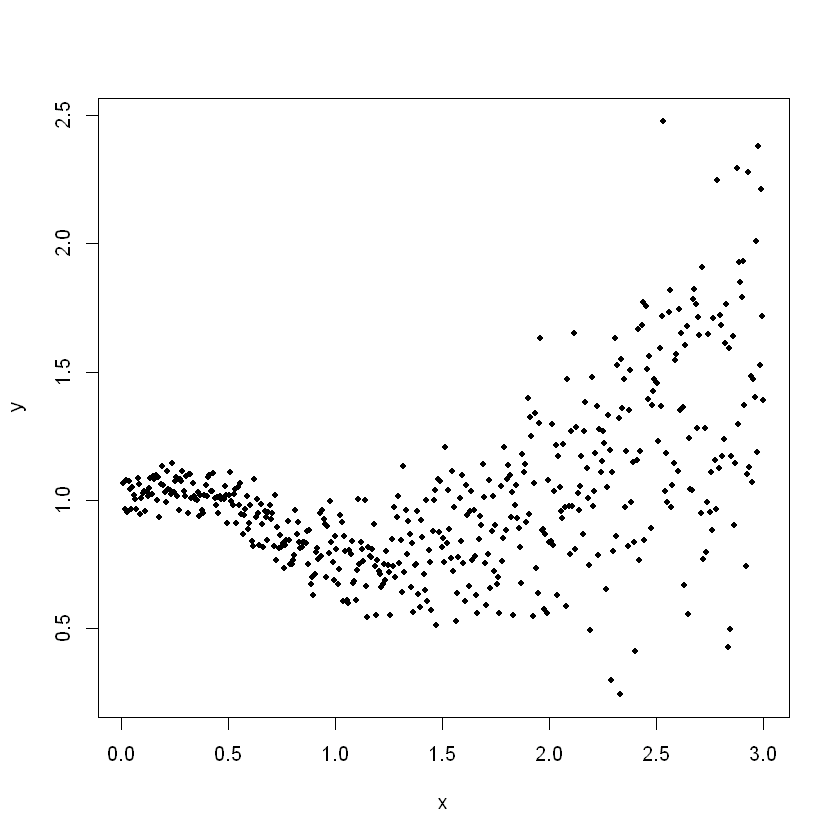

In [2]:
# A bivariate dataset with nonlinear relationship and heteroscedasticity

set.seed(1)
x <- sample(seq(0.01, 3, length.out=500))
y <- 0.5*x + 0.3^(x^2) + rnorm(500, mean=0, sd=(0.05*(1+x^2)))
xy <- cbind(x, y)
plot(xy, pch=20)

We start with a kernel density estimation with a Gaussian kernel chosen with the direct plug-in algorithm.  Here are two graphical displays of a continuous 3D function: a color image with contours, and a perspective plot.  

> **Exercise 1:** Try different kernel widths: different 'scalest' parameter values within dpik.  Try 'locpoly', another smoothing functions in the KernSmooth package.

[1] "Default bandwidth (stdev): 0.296790955202246"
[1] "Bandwidth (iqr): 0.295059869586679"
[1] "Bandwidth (minim): 0.295059869586679"


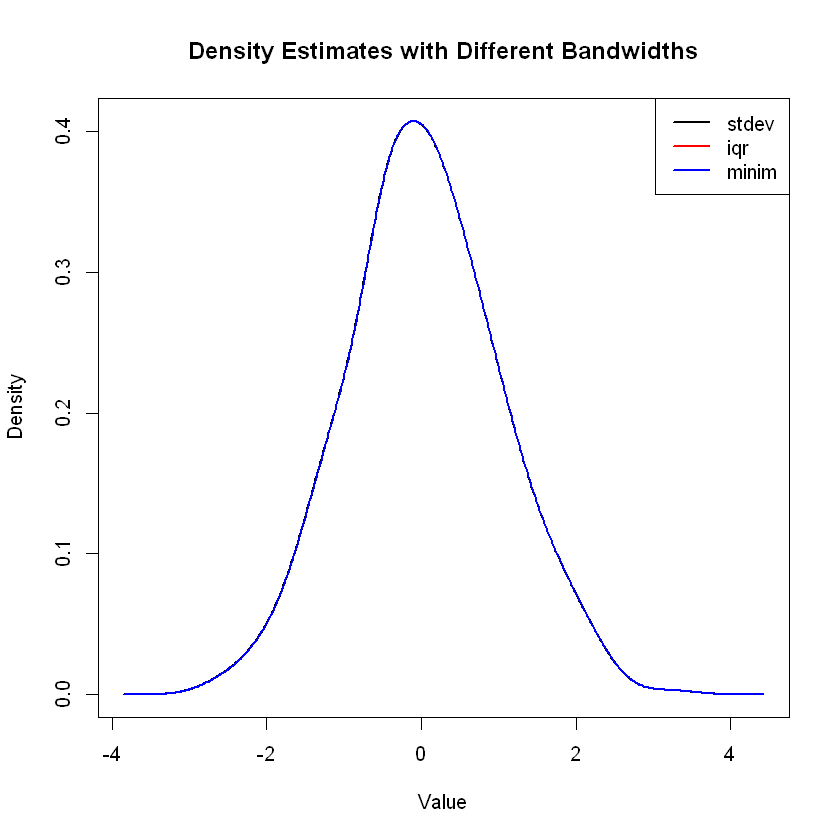

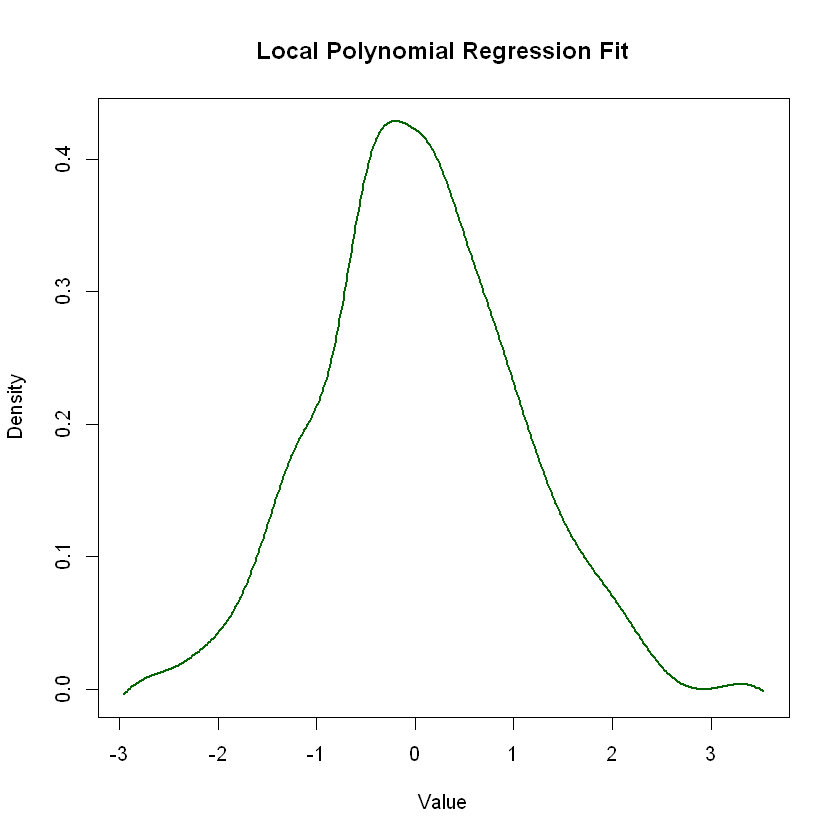

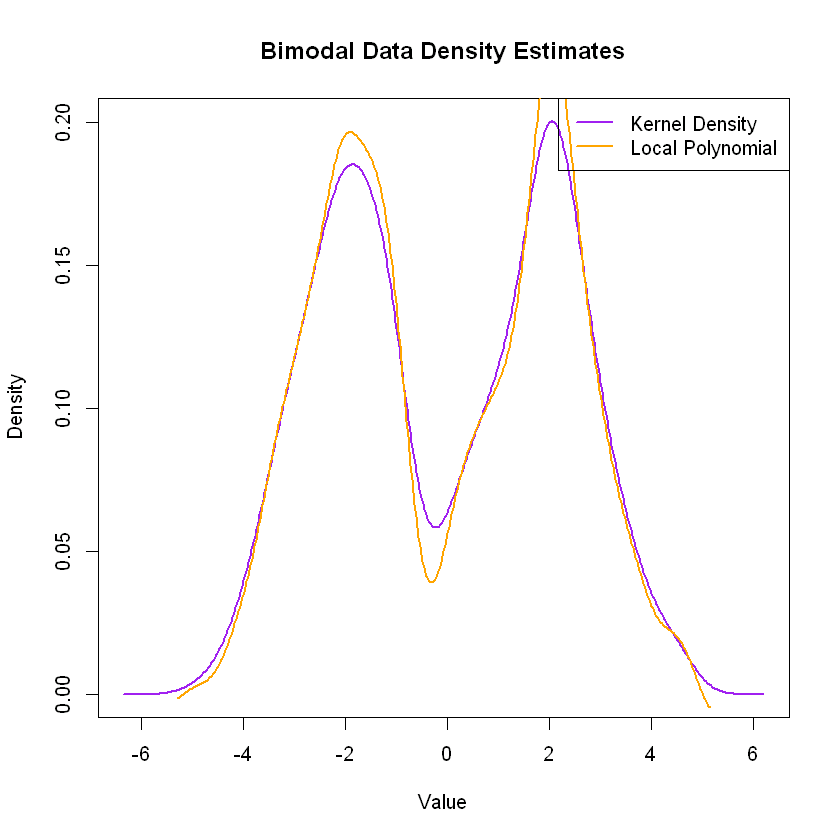

In [6]:
library(KernSmooth)

# Generating Sample Data
set.seed(123)
data <- rnorm(500, mean = 0, sd = 1)  # Normally distributed data
data_bimodal <- c(rnorm(250, mean = -2, sd = 1), rnorm(250, mean = 2, sd = 1))  # Bimodal data

#dpik different scalest parameters
bw_default <- dpik(data, scalest = "stdev")
print(paste("Default bandwidth (stdev):", bw_default))

bw_iqr <- dpik(data, scalest = "iqr")
print(paste("Bandwidth (iqr):", bw_iqr))

bw_minim <- dpik(data, scalest = "minim")
print(paste("Bandwidth (minim):", bw_minim))

# Compute density estimates
est_default <- bkde(data, bandwidth = bw_default)
est_iqr <- bkde(data, bandwidth = bw_iqr)
est_minim <- bkde(data, bandwidth = bw_minim)

# Plot the results
plot(est_default, type = "l", col = "black", lwd = 2, 
     main = "Density Estimates with Different Bandwidths",
     xlab = "Value", ylab = "Density")
lines(est_iqr, col = "red", lwd = 2)
lines(est_minim, col = "blue", lwd = 2)
legend("topright", legend = c("stdev", "iqr", "minim"), 
       col = c("black", "red", "blue"), lwd = 2)

# Using the bandwidth from dpik
lp_fit <- locpoly(x = data, bandwidth = bw_default, degree = 2)

# Plotting the result using locpoly for local polynomial regression
plot(lp_fit, type = "l", col = "darkgreen", lwd = 2,
     main = "Local Polynomial Regression Fit",
     xlab = "Value", ylab = "Density")

# Compute bandwidths for bimodal data
bw_bimodal <- dpik(data_bimodal, scalest = "minim")

# Compute density estimates
est_bimodal <- bkde(data_bimodal, bandwidth = bw_bimodal)
lp_bimodal <- locpoly(x = data_bimodal, bandwidth = bw_bimodal, degree = 2)

# Plot the results
plot(est_bimodal, type = "l", col = "purple", lwd = 2,
     main = "Bimodal Data Density Estimates",
     xlab = "Value", ylab = "Density")
lines(lp_bimodal, col = "orange", lwd = 2)
legend("topright", legend = c("Kernel Density", "Local Polynomial"), 
       col = c("purple", "orange"), lwd = 2)

Warning message:
"package 'KernSmooth' was built under R version 4.4.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009



[1] 0.1966203

[1] 0.04930169

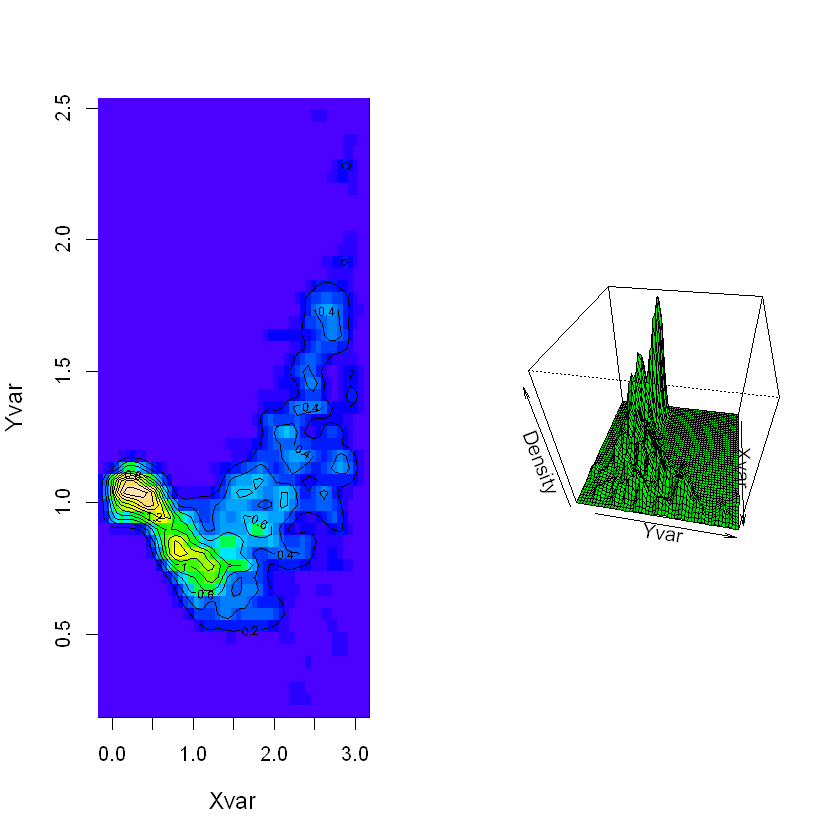

In [3]:
# I. Kernel density estimator with two visualizations

if(!require("KernSmooth", quietly=T)) {
  install.packages("KernSmooth", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library("KernSmooth")
par(mfrow=c(1,2))
dpik(x) ; dpik(y) 
smxy <- bkde2D(xy, bandwidth=c(0.5*dpik(x),0.5*dpik(y)))
image(smxy$x1, smxy$x2, smxy$fhat, col=topo.colors(30), xlab='Xvar', ylab='Yvar', cex.lab=1.2)
contour(smxy$x1, smxy$x2, smxy$fhat, add=T)
persp(smxy$x1,smxy$x2, smxy$fhat, theta=100, phi=40, shade=0.1, col='green', xlab='Xvar', ylab='Yvar', zlab='Density')

### II. Two spline fits

We start with a standard cubic smoothing spline fit.  This function is based on code in a long-established Fortran package. We then proceed with a more modern spline regression that prunes knots based on the Bayesian Information Criterion likelihood measure, and computes spline function for any quantile of dispersion in the response variable.  This combination of local regression and quantile regression is particularly useful in astronomy where the errors (scatter) is often heteroscedastic (depends on the covariates) and asymmetrical.  

> **Exercise 2:** Try different parameter options within COBS such as nknots, degree, lambda, and ic. See help(cobs).  

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


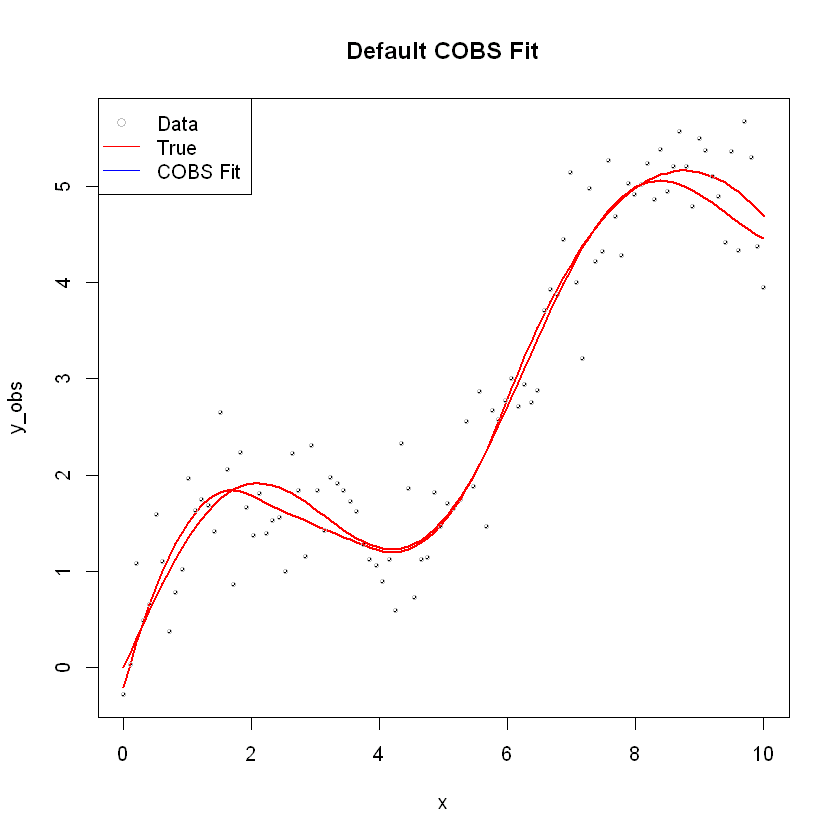

In [12]:
#Exc 2 soln

library(cobs)
library(ggplot2)

# Generating Sample Data
set.seed(123)
x <- seq(0, 10, length.out = 100)
y_true <- sin(x) + 0.5*x
y_obs <- y_true + rnorm(100, sd = 0.5)

# Create a data frame for plotting
df <- data.frame(x = x, y = y_obs, true = y_true)

# Basic COBS fit
fit_default <- cobs(x, y_obs, constraint = "none")
plot(fit_default, main = "Default COBS Fit")
points(x, y_obs, col = "gray", cex = 0.6)
lines(x, y_true, col = "red", lwd = 2)
legend("topleft", legend = c("Data", "True", "COBS Fit"), 
       col = c("gray", "red", "blue"), pch = c(1, NA, NA), lty = c(NA, 1, 1))

qbsks2():
 Performing general knot selection ...

 WARNING! Since the number of  5  knots selected by  AIC  reached the
   upper bound during general knot selection, you might want to rerun
   cobs with a larger number of knots. 

 Deleting unnecessary knots ...

 WARNING! Since the number of  5  knots selected by  AIC  reached the
   upper bound during general knot selection, you might want to rerun
   cobs with a larger number of knots. 
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


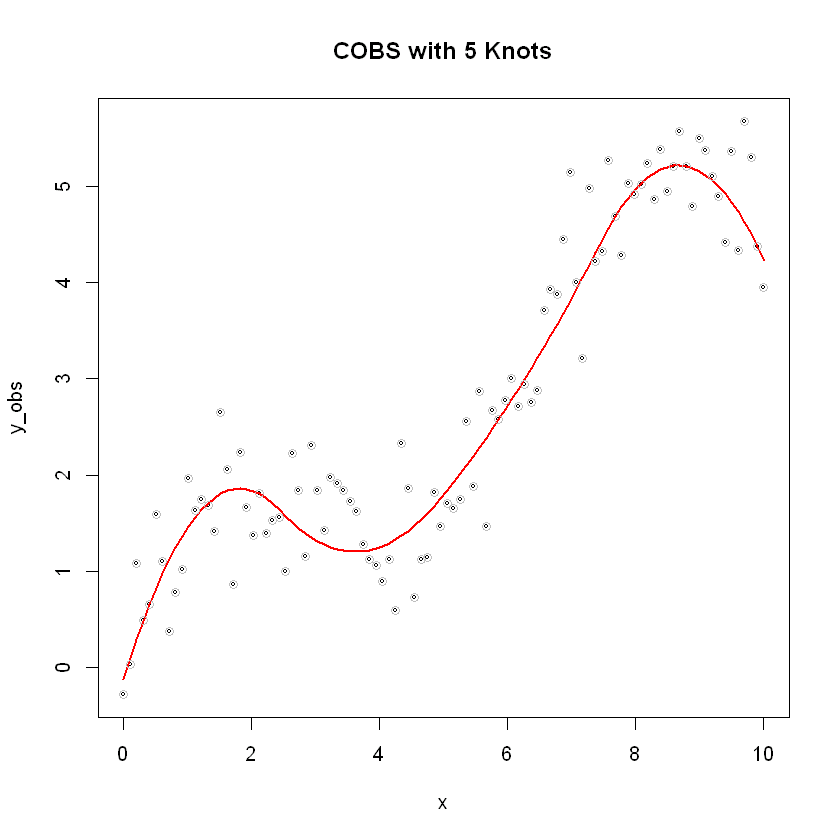

qbsks2():
 Performing general knot selection ...

 WARNING! Since the number of  10  knots selected by  AIC  reached the
   upper bound during general knot selection, you might want to rerun
   cobs with a larger number of knots. 

 Deleting unnecessary knots ...

 WARNING! Since the number of  10  knots selected by  AIC  reached the
   upper bound during general knot selection, you might want to rerun
   cobs with a larger number of knots. 


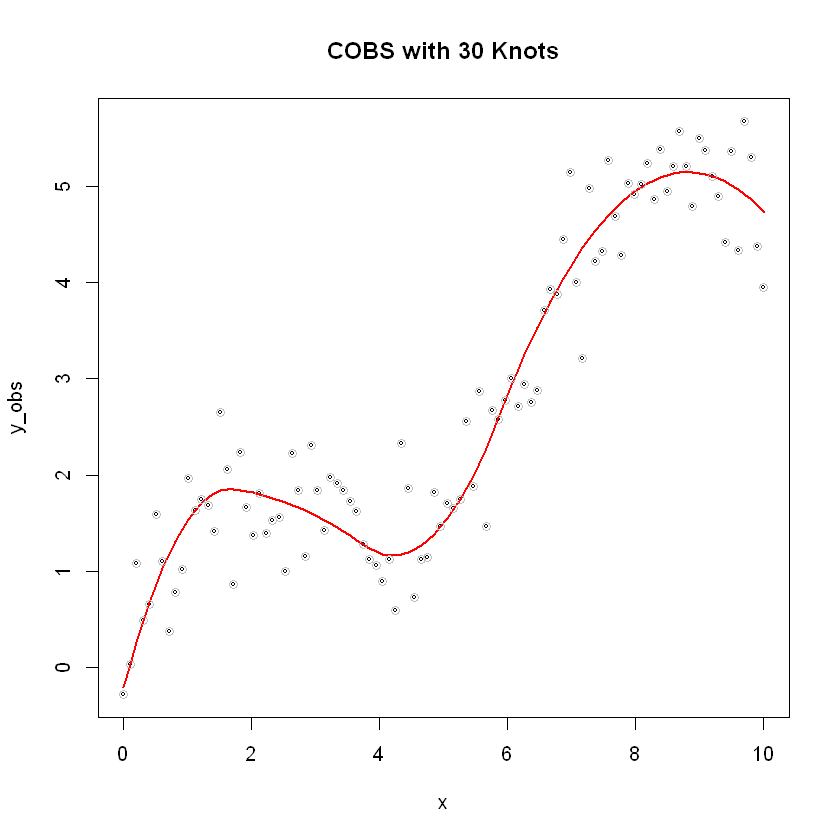

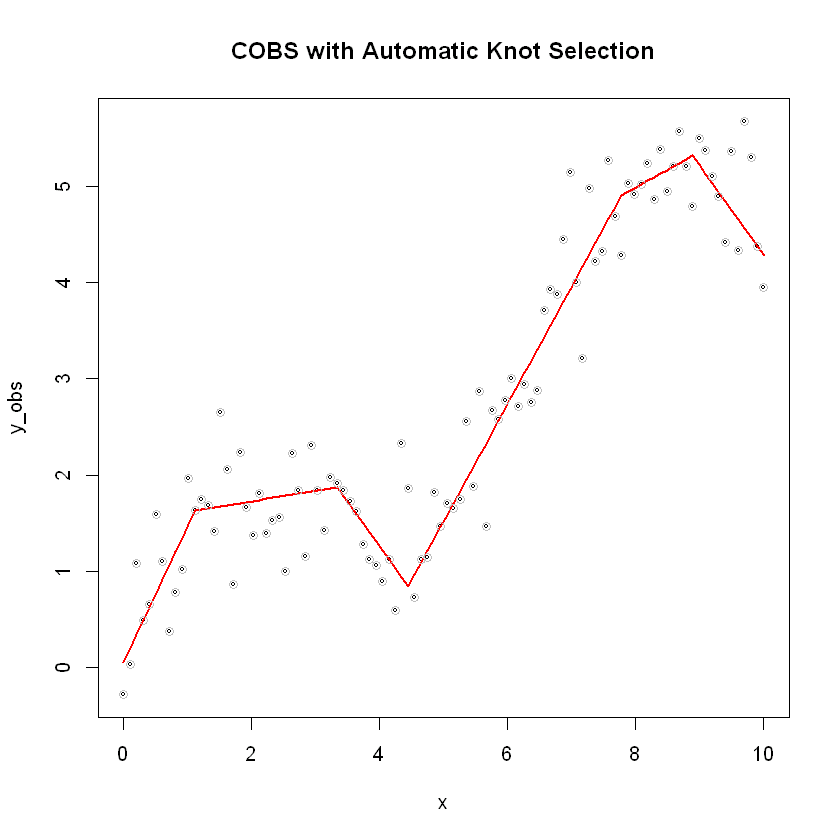

In [25]:
# Exploring nKnots parameter
# Few knots (underfitting)
fit_nknots_low <- cobs(x, y_obs, nknots = 5, constraint = "none")
plot(fit_nknots_low, main = "COBS with 5 Knots")
points(x, y_obs, col = "gray")

# Many knots (potential overfitting)
fit_nknots_high <- cobs(x, y_obs, nknots = 30, constraint = "none")
plot(fit_nknots_high, main = "COBS with 30 Knots")
points(x, y_obs, col = "gray")

# Automatic knot selection (default)
fit_nknots_auto <- cobs(x, y_obs, nknots = 10, degree = 1, lambda = 0, constraint = "none")
plot(fit_nknots_auto, main = "COBS with Automatic Knot Selection")
points(x, y_obs, col = "gray")

qbsks2():
 Performing general knot selection ...

 WARNING! Since the number of  6  knots selected by  AIC  reached the
   upper bound during general knot selection, you might want to rerun
   cobs with a larger number of knots. 

 Deleting unnecessary knots ...

 WARNING! Since the number of  6  knots selected by  AIC  reached the
   upper bound during general knot selection, you might want to rerun
   cobs with a larger number of knots. 
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


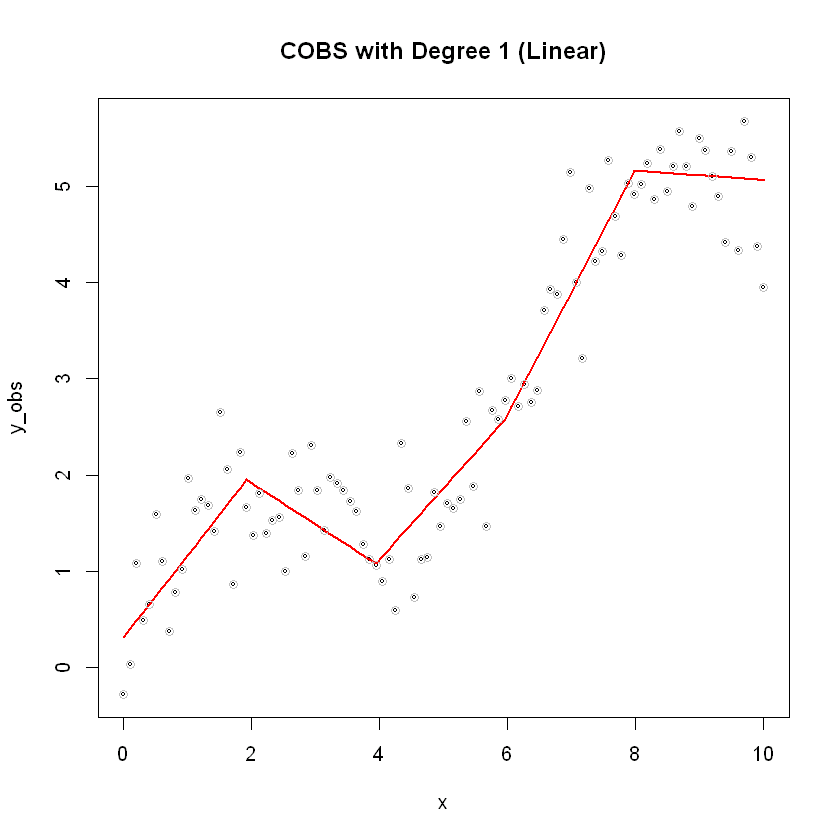

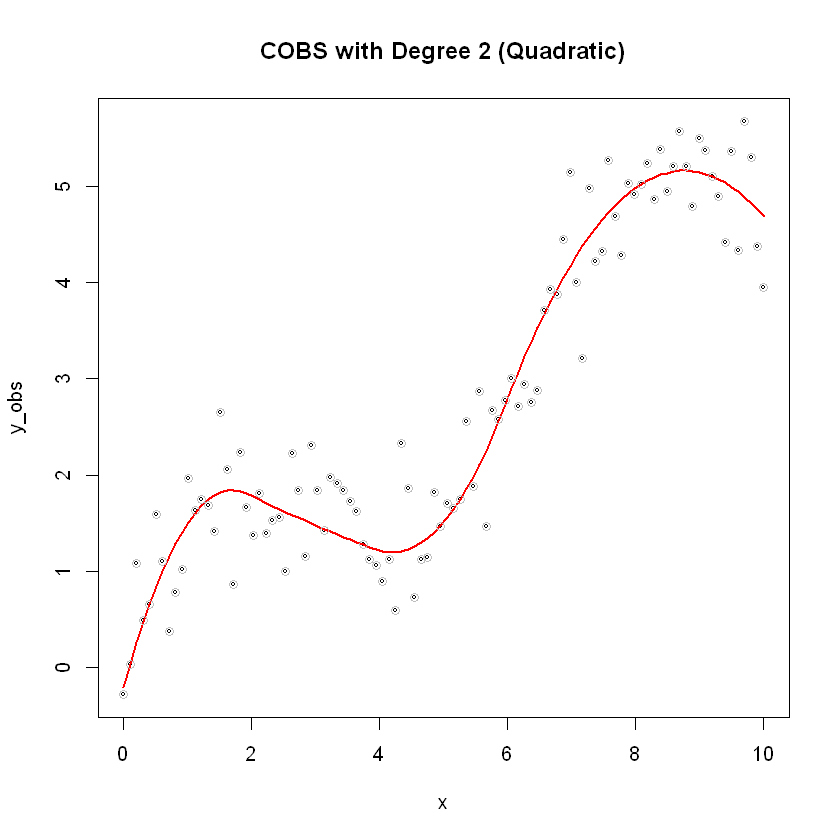

In [22]:
#Exploring Degree parameter
# Linear splines (degree = 1)
fit_degree1 <- cobs(x, y_obs, degree = 1, constraint = "none")
plot(fit_degree1, main = "COBS with Degree 1 (Linear)")
points(x, y_obs, col = "gray")

# Quadratic splines (degree = 2)
fit_degree2 <- cobs(x, y_obs, degree = 2, constraint = "none")
plot(fit_degree2, main = "COBS with Degree 2 (Quadratic)")
points(x, y_obs, col = "gray")

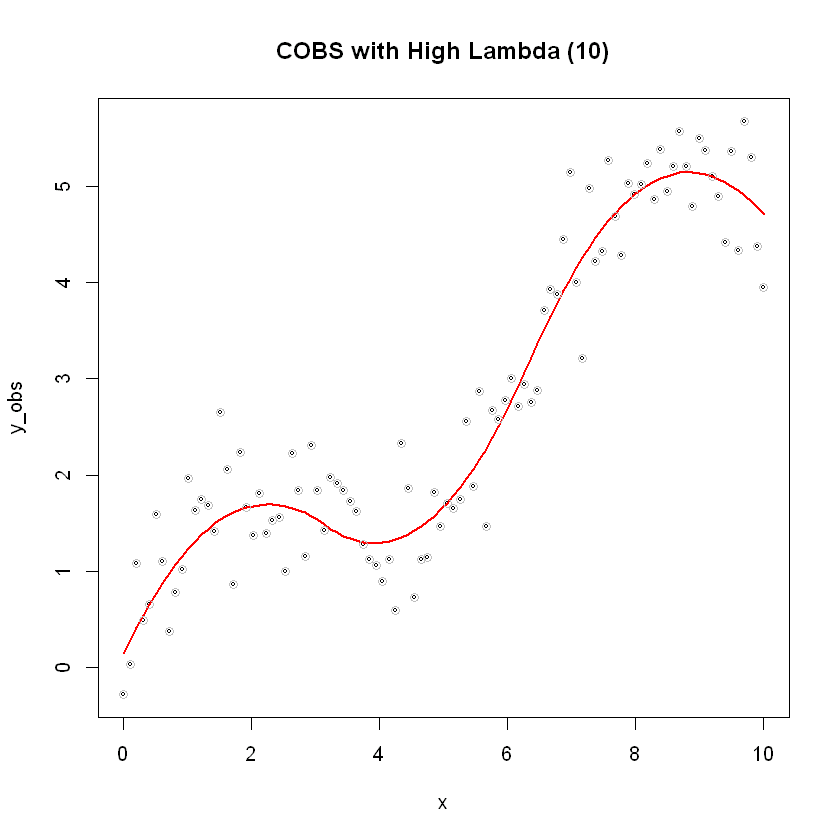

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


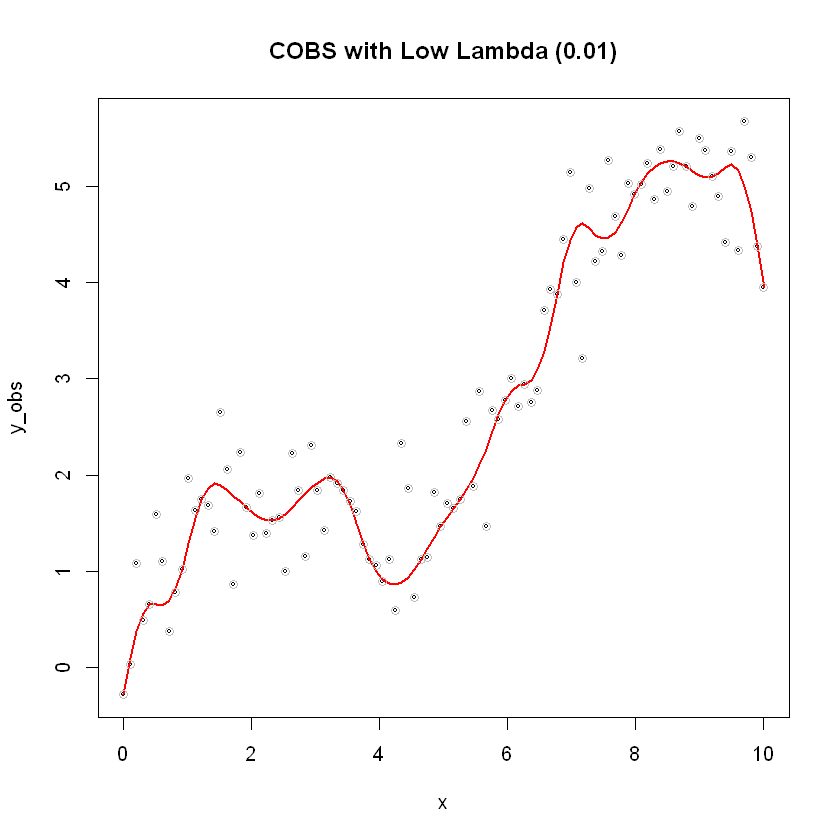

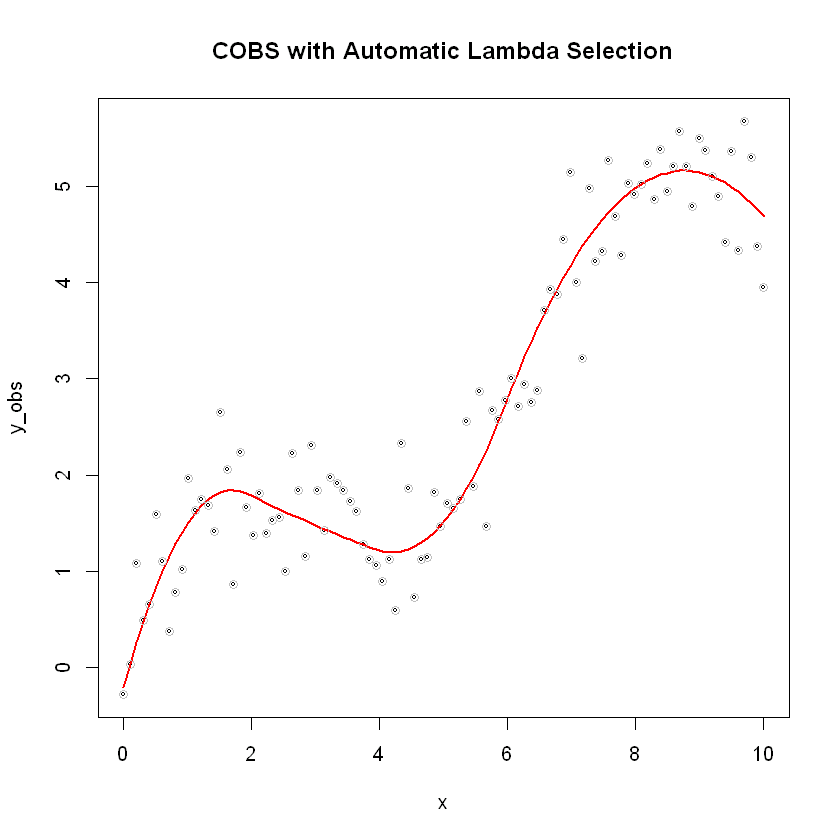

In [19]:
# Exploring Lambda parameter
# Very smooth (high lambda)
fit_lambda_high <- cobs(x, y_obs, lambda = 10, constraint = "none")
plot(fit_lambda_high, main = "COBS with High Lambda (10)")
points(x, y_obs, col = "gray")

# Less smooth (low lambda)
fit_lambda_low <- cobs(x, y_obs, lambda = 0.01, constraint = "none")
plot(fit_lambda_low, main = "COBS with Low Lambda (0.01)")
points(x, y_obs, col = "gray")

# Automatic lambda selection (default)
fit_lambda_auto <- cobs(x, y_obs, lambda = 0, constraint = "none")
plot(fit_lambda_auto, main = "COBS with Automatic Lambda Selection")
points(x, y_obs, col = "gray")

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


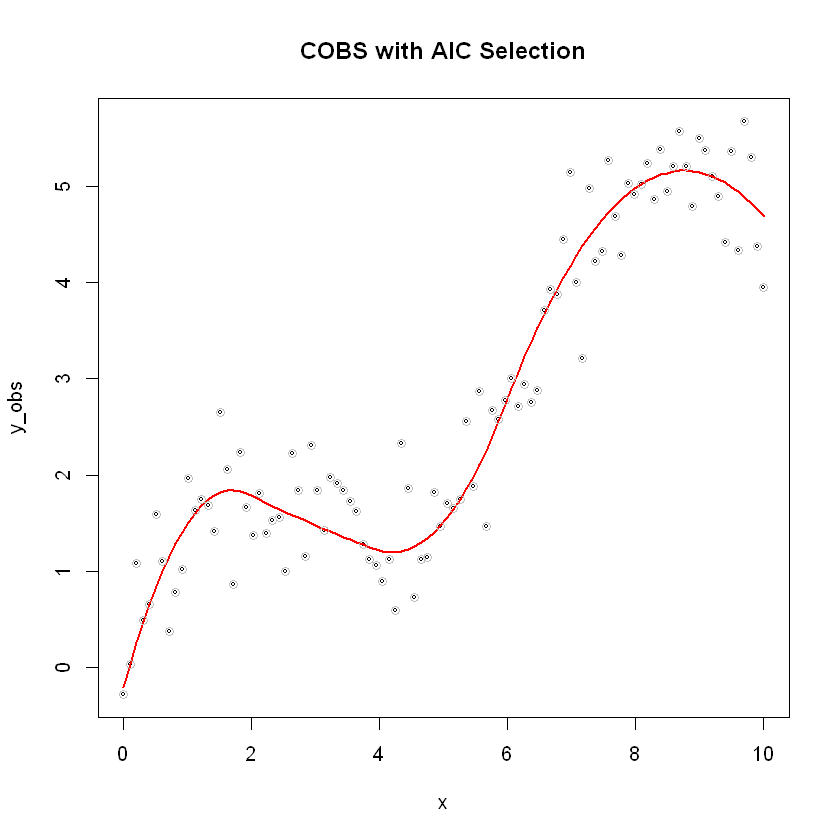

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


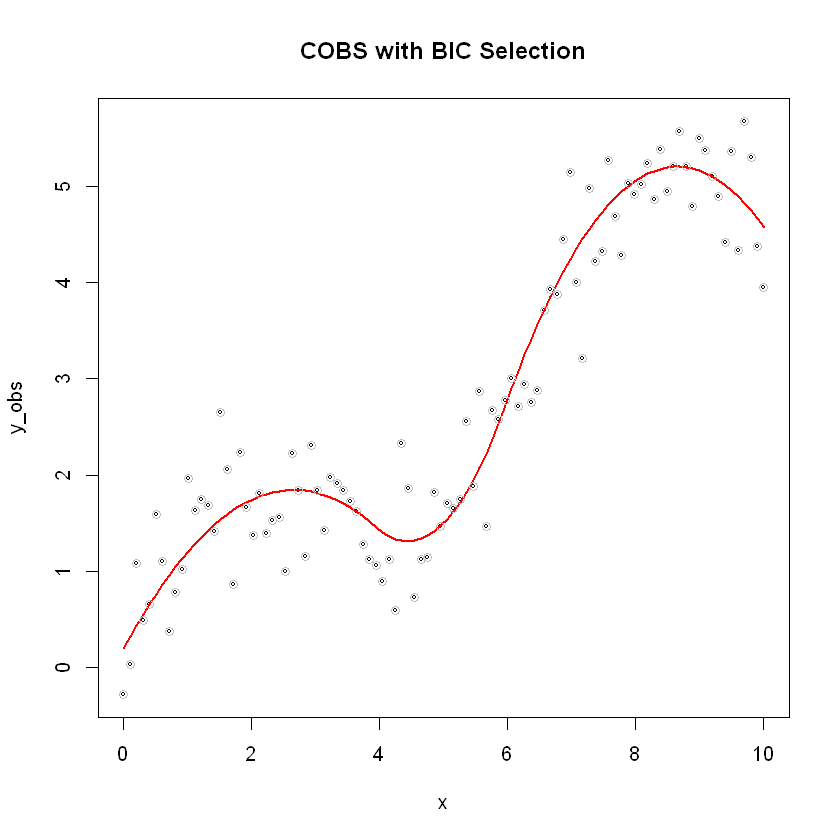

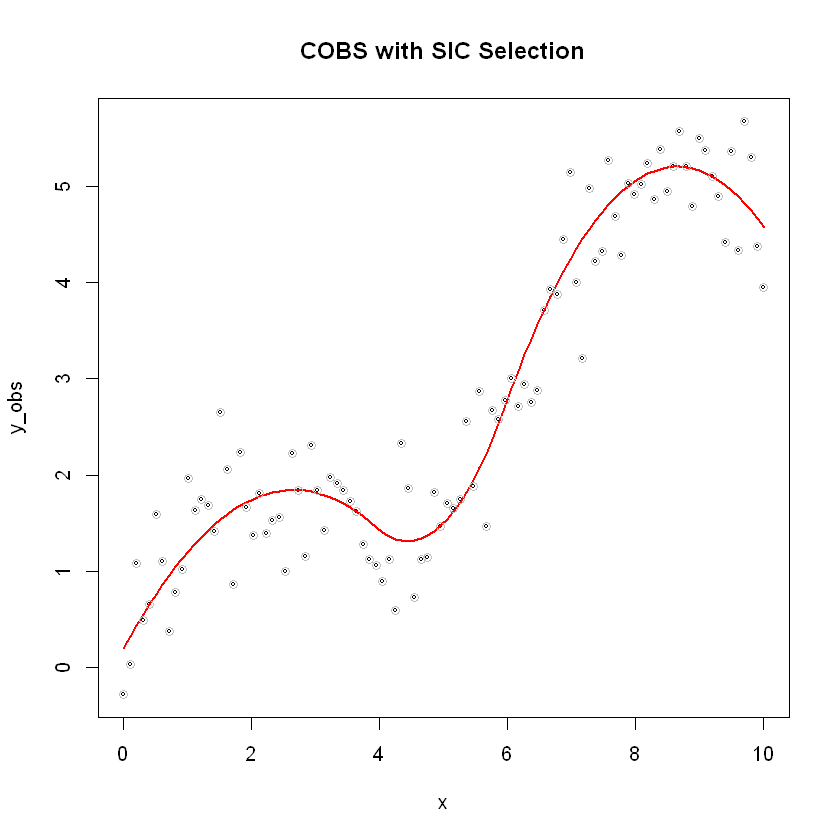

In [18]:
#Exploring ic parameter
# Akaike Information Criterion
fit_aic <- cobs(x, y_obs, ic = "AIC", constraint = "none")
plot(fit_aic, main = "COBS with AIC Selection")
points(x, y_obs, col = "gray")

# Bayesian Information Criterion (default)
fit_bic <- cobs(x, y_obs, ic = "BIC", constraint = "none")
plot(fit_bic, main = "COBS with BIC Selection")
points(x, y_obs, col = "gray")

# Shibata's model selector
fit_sic <- cobs(x, y_obs, ic = "SIC", constraint = "none")
plot(fit_sic, main = "COBS with SIC Selection")
points(x, y_obs, col = "gray")

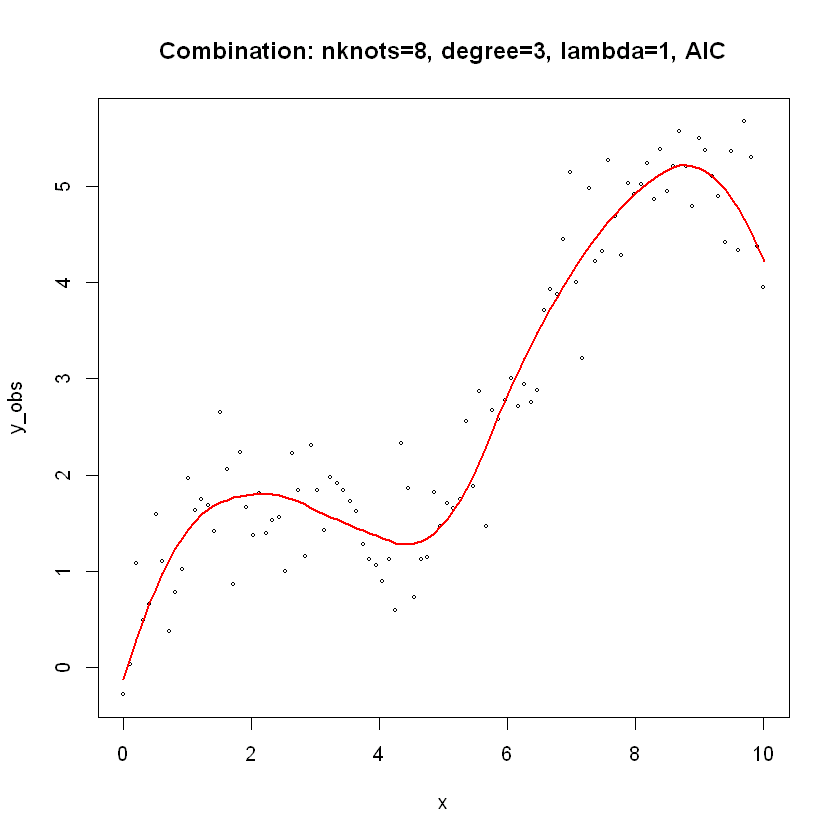

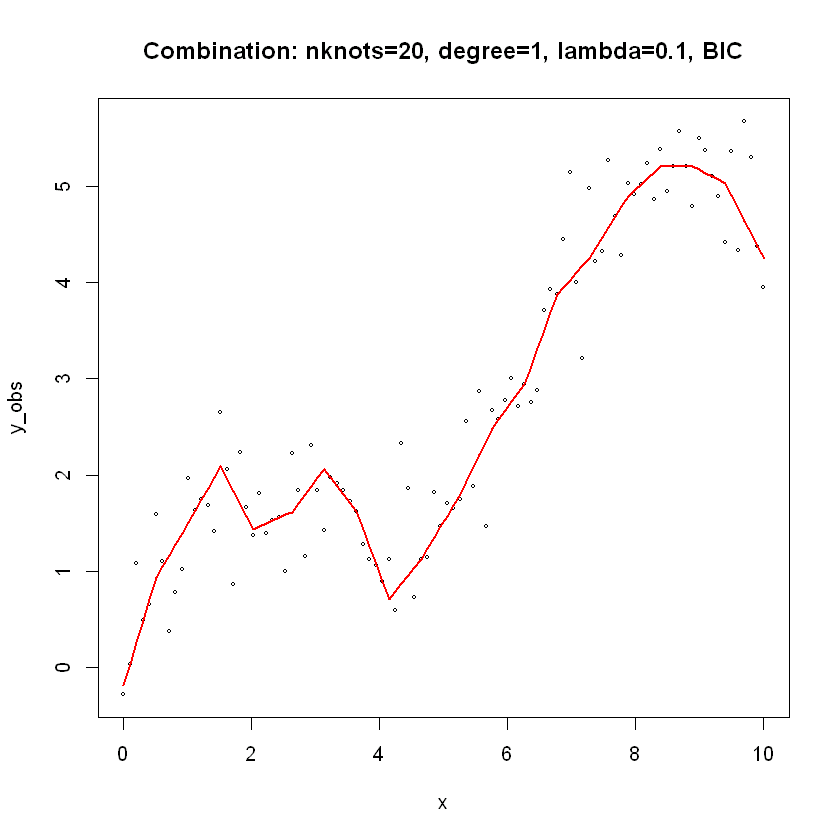

In [16]:
# Combination 1: Few knots, high degree
fit_combo1 <- cobs(x, y_obs, nknots = 8, degree = 2, lambda = 1, ic = "AIC")
plot(fit_combo1, main = "Combination: nknots=8, degree=3, lambda=1, AIC")

# Combination 2: Many knots, low degree
fit_combo2 <- cobs(x, y_obs, nknots = 20, degree = 1, lambda = 0.1, ic = "BIC")
plot(fit_combo2, main = "Combination: nknots=20, degree=1, lambda=0.1, BIC")

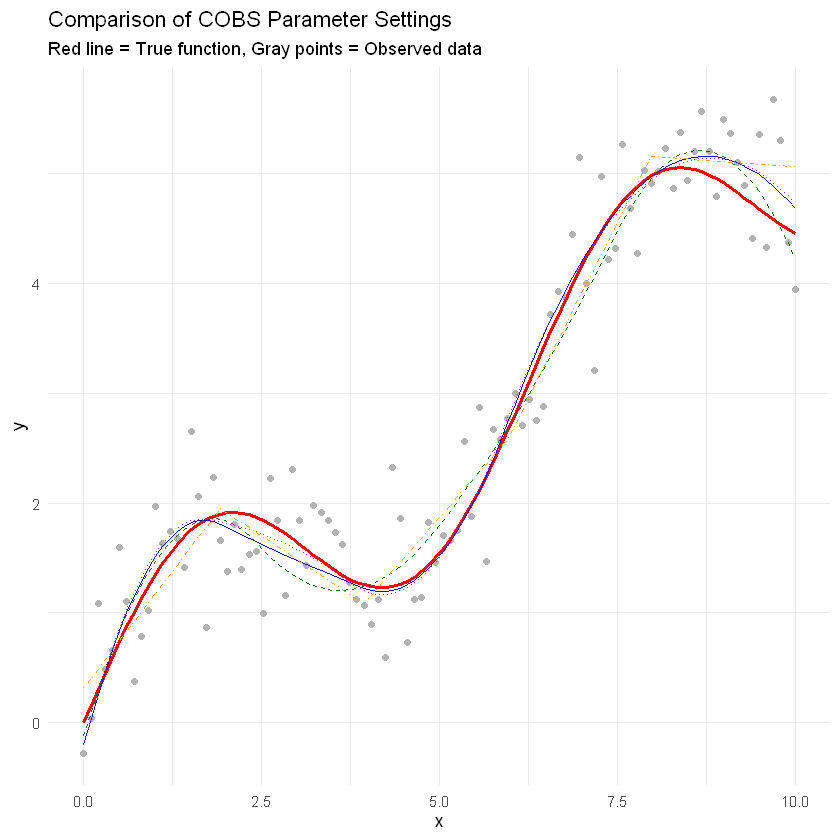

In [26]:
library(ggplot2)

# Create predictions for each model
df$default <- predict(fit_default, x)[,2]
df$nknots5 <- predict(fit_nknots_low, x)[,2]
df$nknots30 <- predict(fit_nknots_high, x)[,2]
df$degree1 <- predict(fit_degree1, x)[,2]
df$degree2 <- predict(fit_degree2, x)[,2]
df$lambda_high <- predict(fit_lambda_high, x)[,2]
df$lambda_low <- predict(fit_lambda_low, x)[,2]

# Create comparison plot
ggplot(df) +
  geom_point(aes(x, y), color = "gray70") +
  geom_line(aes(x, true), color = "red", linewidth = 1) +
  geom_line(aes(x, default), color = "blue", linetype = "solid") +
  geom_line(aes(x, nknots5), color = "darkgreen", linetype = "dashed") +
  geom_line(aes(x, nknots30), color = "purple", linetype = "dotted") +
  geom_line(aes(x, degree1), color = "orange", linetype = "dotdash") +
  labs(title = "Comparison of COBS Parameter Settings",
       subtitle = "Red line = True function, Gray points = Observed data",
       x = "x", y = "y") +
  theme_minimal()

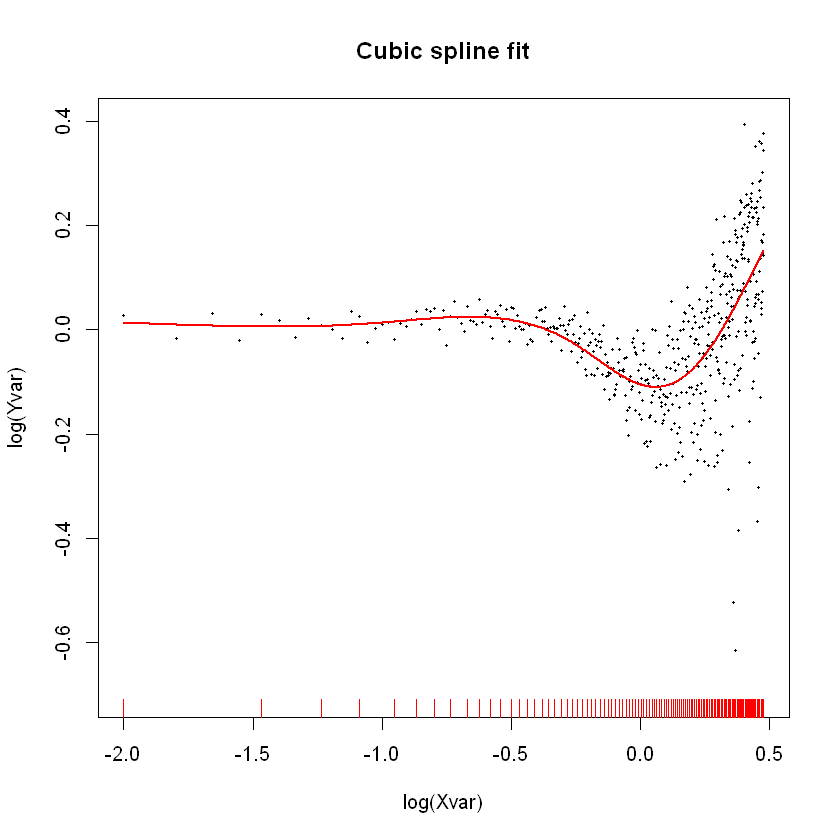

In [4]:
# Classic spline fit 

cubsplxy <- smooth.spline(log10(xy))
plot(log10(xy), pch=20, cex=0.5, ylim=c(-0.7, 0.4), xlab='log(Xvar)', 
     ylab='log(Yvar)', main='Cubic spline fit')  # Plot points
lines(cubsplxy, lwd=2, col='red')  # Plot the spline fit
knotx <- cubsplxy$fit$knot*cubsplxy$fit$range + cubsplxy$fit$min   # Find and plot the spline knots
rug(knotx,col='red')

also installing the dependencies 'MatrixModels', 'SparseM', 'quantreg'




package 'MatrixModels' successfully unpacked and MD5 sums checked
package 'SparseM' successfully unpacked and MD5 sums checked
package 'quantreg' successfully unpacked and MD5 sums checked
package 'cobs' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Time27.B1729\AppData\Local\Temp\RtmpcjPJMN\downloaded_packages


Warning message:
"package 'cobs' was built under R version 4.4.3"


qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...
qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


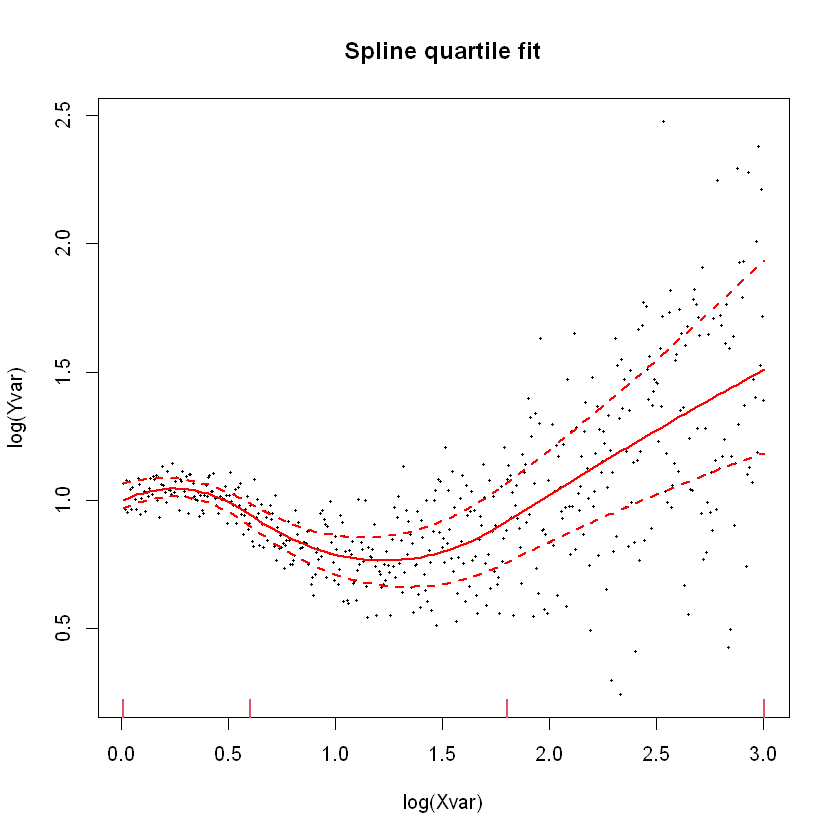

In [5]:
# COnstrained B-Splines Nonparametric Regression Quantiles
# Bartels, R. and Conn A. (1980) Linearly Constrained Discrete L_1 Problems, ACM Transaction on Mathematical Software 6, 594Ã¢â‚¬â€œ608.
# Ng, P. (1996) An Algorithm for Quantile Smoothing Splines, Computational Statistics & Data Analysis 22, 99Ã¢â‚¬â€œ118.
# He, X. and Ng, P. (1999) COBS: Qualitatively Constrained Smoothing via Linear Programming; Computational Statistics 14, 315Ã¢â‚¬â€œ337.
# Ng, P. and Maechler, M. (2007) A Fast and Efficient Implementation of Qualitatively Constrained Quantile Smoothing Splines, Statistical Modelling 7(4), 315-328.

if(!require("cobs", quietly=T)) {
  install.packages("cobs", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library("cobs")
plot(xy, pch=20, cex=0.5, xlab='log(Xvar)', ylab='log(Yvar)', 
	main='Spline quartile fit')  # Plot points
lines(predict(cobs(x,y, ic='BIC', tau=0.25)), col='red', lw=2, lty=2)
lines(predict(cobs(x,y, ic='BIC', tau=0.50)), col='red', lw=2)
lines(predict(cobs(x,y, ic='BIC', tau=0.75)), col='red', lw=2, lty=2)
rug(cobs(x,y, ic='BIC', tau=0.50)$knots, lwd=2, col=2)

### III. Four well-established bivariate semi-parametric local regression estimators

1. LOESS, 'LOcal regrESSion' in base-R, widely used (0.3M Google hits). Local polynomial regression with robust treatment of outliers.  Description in [Wikipedia](https://en.wikipedia.org/wiki/Local_regression).   Presented in the book W. S. Cleveland, `Visualizing Data', Hobart Press 1993

2. Nonparametric regression with bootstrap errors in CRAN package 'np'. See Hayfield, T. & Racine, J. S. Nonparametric Econometrics: The np package, [J. Statist. Software, 27(5), 2008](http://www.jstatsoft.org/v27/i05/).

3. Locfit in CRAN package 'locfit', widely used (>200 downloads/day).  Local kernel regression methods including heteroscedastic weighting (unequal error bars), censoring (upper limits), and outliers.  Presented in the book Loader, C. (1999) _Local Regression and Likelihood_ Springer, New York.

4. Gaussian Process regression, commonly known as `kriging`. Response variable errors and independent variable covariance are assumed to be normal.  Maximum likelihood & Bayesian estimation.  Description in book  Rasmussen & Williams, Gaussian Processes for Machine Learning, 2006.   Other Gaussian processes regression codes are given in CRAN packages
'mlegp' (Maximum Likelihood Estimates of Gaussian Processes) and 'gptk'
(Gaussian Processes tool-kit). See also the tutorial [here](http://www.r-bloggers.com/gaussian-process-regression-with-r/). 

Finally, we plot all of these nonparametric regressions on the same plot.  We find that, in this case, they are quite compatible with each other.

> **Exercise 3:**  Choose one of these methods, read the help file, and play around with the input parameters.  Note that sometimes multiple functions are involved, such as _loess.control_ associated with _loess_, and _locfit.raw_ and _lp_ associated with _locfit_.

> **Exercise 4:** Perhaps the most capable of these packages, with strong foundations in likelihood theory, is Clive Loader's _locfit_ written in the early years of R.   It incorporates complexities such as survival analysis for nondetections, robust regression for non-Gaussian scatter, and heteroscedasticity for measurement error weighting.  To exercise _locfit_ well, it is necessary to get a hold of the 1999 Springer book by Loader, which unfortunately is not available in electronic form.  


In [0]:
# LOESS,  W. S. Cleveland, `Visualizing Data', Hobart Press 1993

par(mfrow=c(1,1))
sortx <- x[order(x)] ; sorty <- y[order(x)]
local_fit <- loess(sorty ~ sortx, span=0.25, data.frame(x=x,y=y))	
summary(local_fit)
plot(x,y,pch=20, cex=0.5, main='LOESS')
lines(sortx, predict(local_fit), lwd=2, col=2)

# Save evenly-spaced LOESS fit to a file 

x_seq <- seq(0.0, 3.0, by=0.03) 
loc_dat <- predict(local_fit, newdata=x_seq)
write(rbind(x_seq,loc_dat), sep=' ', ncol=2, file='localfit.txt')

In [0]:
# Nonparametric regression with bootstrap errors
# Hayfield, T. & Racine, J. S. Nonparametric Econometrics: The np package, 
# J. Statist. Software, 27(5), 2008   http://www.jstatsoft.org/v27/i05/

if(!require("np", quietly=T)) {
  install.packages("np", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library("np")
bw.NW <- npregbw(x, y, regtype='lc', bwtype='fixed')
# help(npregbw)
# help(npplot)
# str(bw.NW)
# bw.NW$bw <- 0.5 * bw.NW$bw
# cat('New bandwidth for np local regression = ', bw.NW$bw)
npplot(bws=bw.NW, ylim=c(0.0,2.5), plot.errors.method="bootstrap", 
    plot.errors.bar='I', plot.errors.type='quantiles', main='NP with bootstrap CI') 
points(x, y, pch=20, cex=0.5)

In [0]:
# Locfit: local kernel regression methods including heteroscedastic weighting
# (unequal error bars), censoring (upper limits), and outliers.
# Loader, C. (1999). Local Regression and Likelihood. Springer, New York.
# >200 downloads/day

if(!require("locfit", quietly=T)) {
  install.packages("locfit", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library("locfit")
locfit_model <- locfit(y~lp(x, nn=0.7))
plot(locfit_model, band='local', ylim=c(0,2.5), col=2, main='locfit bandwidth=0.7')  ;  points(xy, pch=20, cex=0.5)
locfit_model <- locfit(y~lp(x, nn=0.3))
plot(locfit_model, band='local', ylim=c(0,2.5), col=3, main='locfit bandwidth=0.3')  ;  points(xy, pch=20, cex=0.5)

In [0]:
# Gaussian process regression (more commonly known as `kriging')
# Response variable errors and independent variable covariance assumed to be normal
# Maximum likelihood & Bayesian estimation
# Rasmussen & Williams, Gaussian Processes for Machine Learning, 2006

if(!require("kernlab", quietly=T)) {
  install.packages("kernlab", repos="https://cloud.r-project.org", dependencies=TRUE)
}; library("kernlab")
gpreg <- gausspr(x, y, variance.model=T, cross=10, kerne='polydot', kpar=list(5))
gpreg
xtest <- seq(from=min(x), to=max(x), length.out=200)
plot(x, y, pch=20, cex=0.5, main='GP regression')
lines(xtest, predict(gpreg, xtest), col='red3', lwd=3)

In [0]:
# Plot several smooth density estimators on a single graph

npplot(bws=bw.NW, ylim=c(0.5,1.5), plot.errors.method="bootstrap",
plot.errors.bar='I', plot.errors.type='quantiles') 	# Nonparametric regression w/ bootstrap errors
points(x, y, pch=20, cex=0.5)
lines(xtest, predict(gpreg, xtest), col='red3', lwd=3)  #  Gaussian Processes regression
lines(predict(cobs(x,y, ic='BIC', tau=0.25)), col='blue3')
lines(predict(cobs(x,y, ic='BIC', tau=0.50)), col='blue3')
lines(predict(cobs(x,y, ic='BIC', tau=0.75)), col='blue3')
lines(sortx, predict(local_fit), lwd=2, col='green') # LOESS
locfit_values <- predict(locfit_model, seq(0,3,length.out=100))
lines(seq(0,3,length.out=100), locfit_values, lwd=2, col="chocolate")  # locfit
legend('topleft', lty=1, lwd=2, c("NP reg w/ bootstrap",'Gauss Proc reg', 'Quantile reg', 'LOESS', 'locfit'), col=c('black', 'red3', 'blue3', 'green', 'chocolate'))